Reload Pytorch model generated by manifold.ipynb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ipywidgets import interact, IntSlider

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


# Reload model

In [3]:
H1, H2 = 200, 200

torch.manual_seed(7) # reproducible

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    torch.nn.Tanh(),
    torch.nn.Linear(H1, H2),
    torch.nn.Tanh(),
    torch.nn.Linear(H2, 74)
)

In [4]:
model.load_state_dict(torch.load('trained_model.pt'))

In [5]:
list(model.parameters())[0]

Parameter containing:
tensor([[-2.4352e-03, -4.0181e-03, -4.0804e-03,  ...,  2.6714e-02,
         -4.7602e-02,  5.0626e-02],
        [ 1.5043e-04,  1.5589e-04, -5.7094e-05,  ...,  1.0584e-03,
         -2.9739e-02, -4.5840e-01],
        [-4.3593e-03, -4.6564e-03, -1.1147e-02,  ...,  2.0942e-03,
          7.5349e-03,  2.4254e-02],
        ...,
        [-3.6774e-04, -9.6016e-04,  1.3600e-04,  ..., -2.1896e-02,
          3.1601e-02, -6.7046e-02],
        [ 9.7104e-03,  1.2451e-02, -6.2524e-03,  ...,  7.4435e-04,
          5.3289e-03, -5.9906e-02],
        [ 8.9143e-04,  3.9392e-04, -3.1082e-04,  ..., -2.3041e-03,
          2.3180e-02, -4.0532e-01]])

In [6]:
y0_list = pd.read_csv('y0.csv', index_col=0).values

In [7]:
y1_list = pd.read_csv('y1.csv', index_col=0).values

In [8]:
%time y2_list = kpp.onestep(np.c_[y1_list, y0_list[:,-1:]].T).T  # use the same SUN as y0
y2_list.shape

CPU times: user 7.63 s, sys: 20 ms, total: 7.65 s
Wall time: 7.43 s


(20000, 74)

# Normalize data

In [9]:
normalizer = StandardScaler()
normalizer.fit(y1_list[:,0:74])

X_train = np.append(normalizer.transform(y1_list[:,0:74]), 
                    y0_list[:,-1:],  # use old SUN !
                    axis=1)
Y_train = normalizer.transform(y2_list)

# ANN prediction

In [10]:
x_torch = torch.tensor(X_train, dtype=torch.float32)
y_torch = torch.tensor(Y_train, dtype=torch.float32)

In [11]:
y_pred = model(x_torch)
y_pred_numpy = y_pred.detach().cpu().numpy()

In [12]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9995687490202976

Text(0,0.5,'neural net prediction')

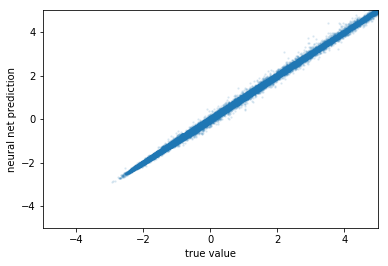

In [13]:
plt.scatter(y_pred_numpy, Y_train, alpha=0.1, s=2.0)
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel('true value')
plt.ylabel('neural net prediction')